In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt

tf.config.threading.set_intra_op_parallelism_threads(64)
tf.config.threading.set_inter_op_parallelism_threads(64)

# Load the data
X = pd.read_csv('predict2.csv')
y = pd.read_csv('response2.csv')

# Replace missing values in y with NaN
y = y.replace("?", np.nan)  # If missing values are marked with "?" in the dataset
y_numeric = y.select_dtypes(include="number")  # Remove 'statecounty'

# Normalize X (remove the 'statecounty' column)
X_numeric = X.select_dtypes(include='number')  # Remove 'statecounty'
X_numeric.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_numeric, test_size=0.2)

In [34]:
#y_train = y_train.fillna(y_train.mean())

In [35]:
X

,Percent_Population_Without_Health_Insurance_ACS2016_20,PercentPopulation_18yrs_And_Under_Without_Health_Insurance_ACS2016_20,Population_19_64yrs_Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20,Population_19_64yrs_Old_With_Health_Insurance_ACS2016_20,Percent_Population_19_64yrs_Old_Without_Health_Insurance_ACS2016_20,Population_65_And_Above_Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20,Population_65yrs_And_Over_With_Health_Insurance_ACS2016_20,Population_16yrs_And_Over_Without_Earning_ACS2016_20,Percent_Population_16yrs_And_Over_Without_Earning_ACS2016_20,Percent_Population_16yrs_And_Over_In_Middle_Class_Or_Upper_Earning_range_ACS2016_20,...,Population_25yrs_and_over_with_STEM_related_Degree_ACS2016_20,Index_For_Environment_With_Access_To_Healthy_Food_2015_17_CHR,Percent_Adults_20yrs_And_Over_Physical_Inactivity_2016_CHR,Percentage_Female_Ages_65_74_Received_Annual_Mammography_Screening_2017_CHR,Percentage_Households_Have_1_Or_More_Issue_WIth_The_House_Facilities_2012_16_CHR,Percent_Population_With_Low_Access_To_Store_USDA_2015,Percent_Household_With_Low_Income_And_Low_Access_to_Store_USDA_2015,Percent_Population_Under_18_With_Low_Access_To_Store_USDA_2015,Amount_of_SNAP_Benefits_Per_Capita_USDA_2017,statecounty
0,-0.077901,-0.459148,0.558164,0.567832,-0.005144,0.363381,0.366013,0.528944,0.170974,0.160601,...,0.636870,-0.384615,0.993377,0.0,0.273026,0.719627,0.778621,0.910873,0.139229,01Autauga County
1,0.168521,0.020050,3.334915,3.239965,0.223251,3.870753,3.857697,3.525758,0.147117,0.110555,...,4.572404,0.230769,-0.092715,0.2,0.049789,-0.136724,-0.155002,-0.125795,-0.298208,01Baldwin County
2,0.354531,-0.360902,-0.066140,-0.078791,0.586420,-0.014054,-0.012802,0.133523,1.296664,-1.030482,...,-0.166197,-1.615385,-0.490066,0.4,0.256724,0.162154,0.600694,-0.145244,1.284787,01Barbour County
3,0.095390,-0.657644,-0.057359,-0.055173,0.221193,-0.114749,-0.113239,0.038611,1.009499,-0.730209,...,-0.165958,0.076923,0.834437,-0.1,-0.574747,-0.838677,-0.556334,-0.761354,0.247178,01Bibb County
4,0.251192,-0.112281,0.582074,0.555637,0.313786,0.537748,0.537825,0.754790,0.785067,-0.130573,...,0.153496,0.538462,0.410596,-0.7,-0.564257,-0.711745,-0.516735,-0.632549,-0.217580,01Blount County
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,0.914149,2.576441,-0.267904,-0.265458,0.521605,-0.277676,-0.276549,-0.338362,-0.460791,1.062329,...,-0.124019,0.615385,-0.635762,-1.2,-1.726320,-0.013727,-0.370660,-0.229598,-1.154980,56Sublette County
3138,0.531002,0.998496,0.359542,0.346229,0.262346,0.045712,0.044732,0.065787,-0.787718,0.967698,...,0.343299,0.000000,-0.291391,-0.4,-0.704664,1.344576,0.615717,1.498739,-0.817228,56Sweetwater County
3139,0.475358,1.014536,0.036067,0.036180,0.209877,-0.123034,-0.121543,-0.268705,-1.621825,1.825751,...,0.848242,0.384615,-2.066225,0.1,0.741867,0.557935,0.127222,0.166848,-1.288982,56Teton County
3140,0.446741,0.517293,-0.089435,-0.091827,0.363169,-0.184674,-0.185305,-0.227679,-0.735586,0.550045,...,-0.052364,-0.230769,0.000000,-1.0,-0.382762,0.166864,0.456740,0.541325,-0.568627,56Uinta County


In [36]:
print(X_train.isnull().sum())
print(X_train.isin([np.inf, -np.inf]).sum())
print(y_train.isnull().sum())


Percent_Population_Without_Health_Insurance_ACS2016_20                                                0
PercentPopulation_18yrs_And_Under_Without_Health_Insurance_ACS2016_20                                 0
Population_19_64yrs_Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20        0
Population_19_64yrs_Old_With_Health_Insurance_ACS2016_20                                              0
Percent_Population_19_64yrs_Old_Without_Health_Insurance_ACS2016_20                                   0
Population_65_And_Above_Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20    0
Population_65yrs_And_Over_With_Health_Insurance_ACS2016_20                                            0
Population_16yrs_And_Over_Without_Earning_ACS2016_20                                                  0
Percent_Population_16yrs_And_Over_Without_Earning_ACS2016_20                                          0
Percent_Population_16yrs_And_Over_In_Middle_Class_Or_Upper_Earni

In [37]:
def masked_loss(y_true, y_pred):
    mask = tf.math.is_finite(y_true)  # Create a mask to ignore NaNs
    diff = tf.boolean_mask(y_true - y_pred, mask)  # Ignore NaNs
    return tf.reduce_mean(tf.square(diff))

def build_model(hp):
    model = tf.keras.models.Sequential()
    input_dim = X_train.shape[1]  # Ensure correct input dimension
    model.add(tf.keras.layers.InputLayer(input_shape=(input_dim,)))

    # Tune number of layers and units
    for i in range(hp.Int('num_layers', 2, 3)):  # Between 2 and 3 layers
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                     min_value=128,
                                                     max_value=256,  # Adjust range
                                                     step=64),
                                        activation='relu'))
        model.add(tf.keras.layers.Dropout(hp.Float('dropout_' + str(i),
                                                   min_value=0.2,
                                                   max_value=0.4,
                                                   step=0.1)))

    # Output layer matching y_train shape
    output_dim = y_train.shape[1] if len(y_train.shape) > 1 else 1
    model.add(tf.keras.layers.Dense(output_dim, activation='linear'))

    # Compile model with masked loss
    model.compile(optimizer=tf.keras.optimizers.Adam(
                      hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),
                  loss=masked_loss,
                  metrics=['mae'])
    return model

# Hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='multi_target_hyperparam_tuning',
    max_consecutive_failed_trials=10
)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [38]:
# tuner.results_summary()


In [39]:

# shap graph starts
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=64, verbose = 1)

best_model = tuner.get_best_models(num_models=1)[0]
loss, mae = best_model.evaluate(X_test, y_test)
print(f"Best Model Test Loss: {loss}, Test MAE: {mae}")

best_model.save('best_multi_target_model.h5')

Trial 20 Complete [00h 00m 12s]
val_mae: 0.4659918248653412

Best val_mae So Far: 0.43685829639434814
Total elapsed time: 00h 04m 13s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3185 - mae: 0.4194  


Best Model Test Loss: 0.3363634943962097, Test MAE: 0.4327808916568756


In [40]:
from tensorflow.keras.models import load_model
import shap
import matplotlib.pyplot as plt

# Load the saved model
best_model = load_model('best_multi_target_model.h5', compile=False)
assert list(X_train.columns) == list(X_test.columns), "Mismatch in feature columns"


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


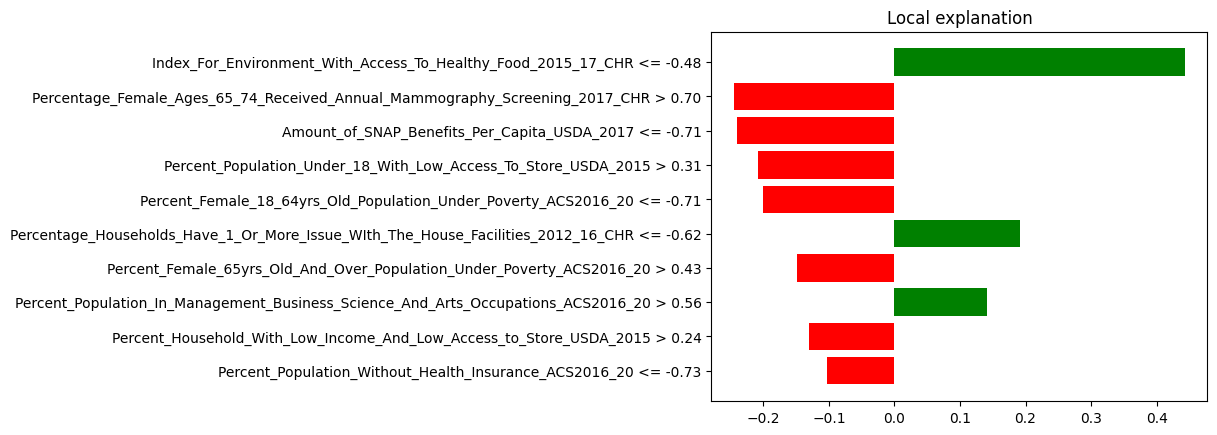

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


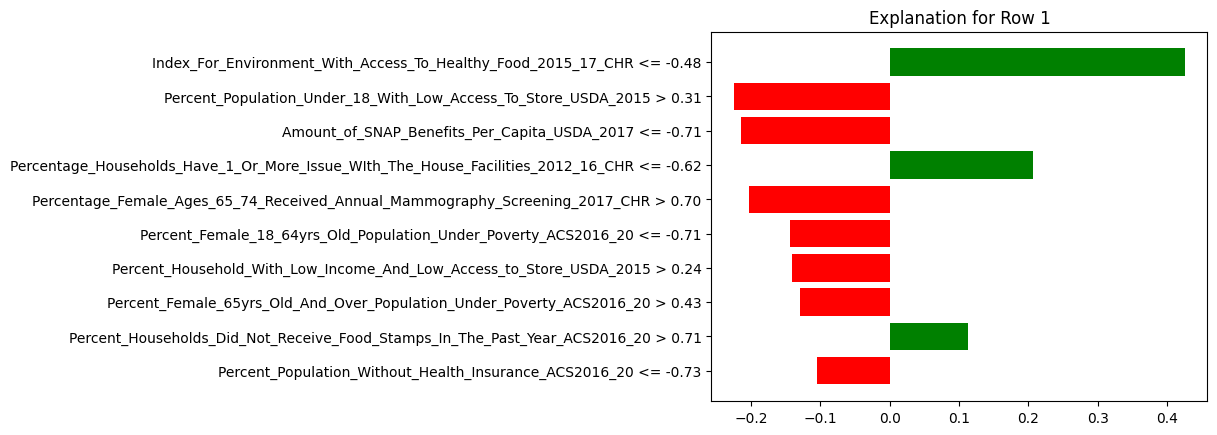

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


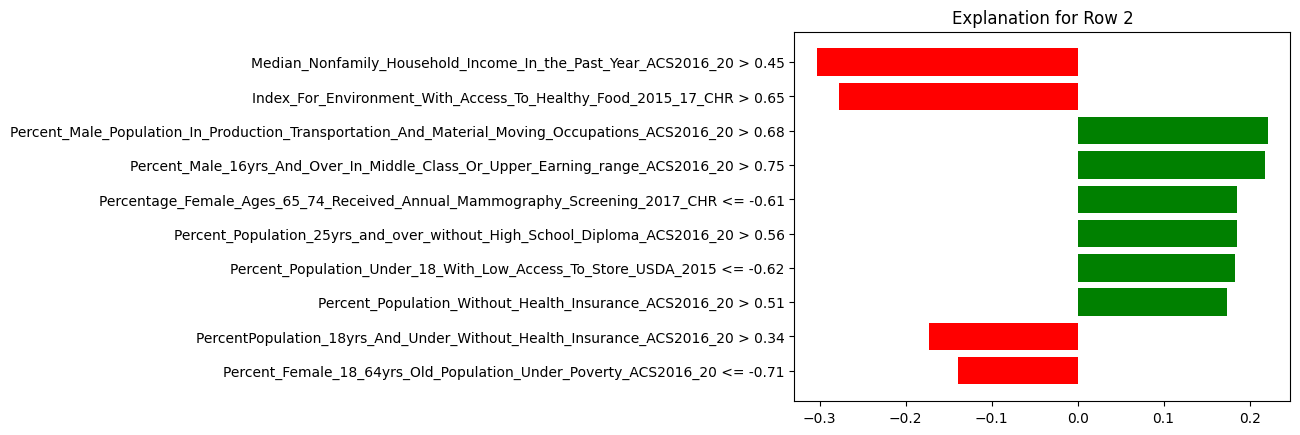

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


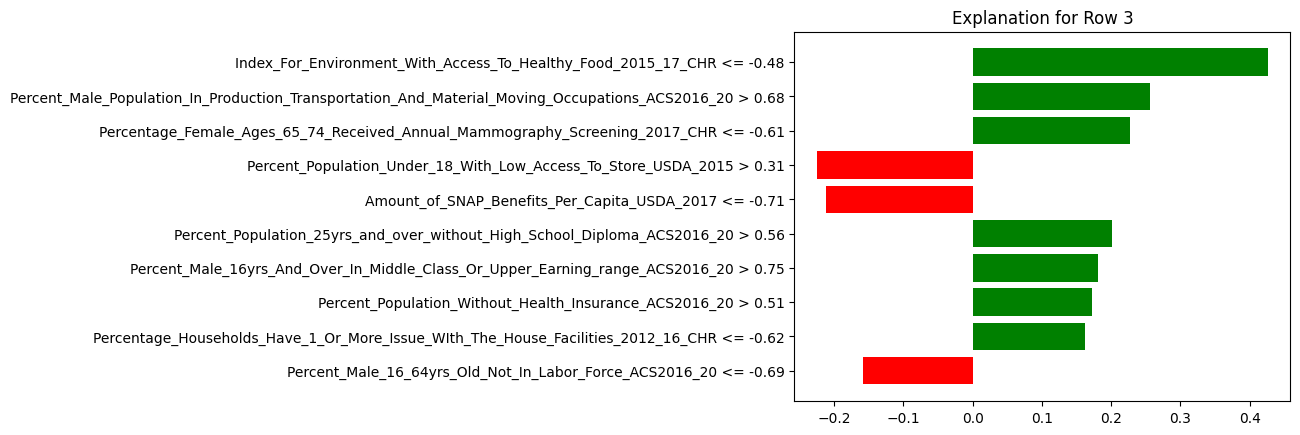

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


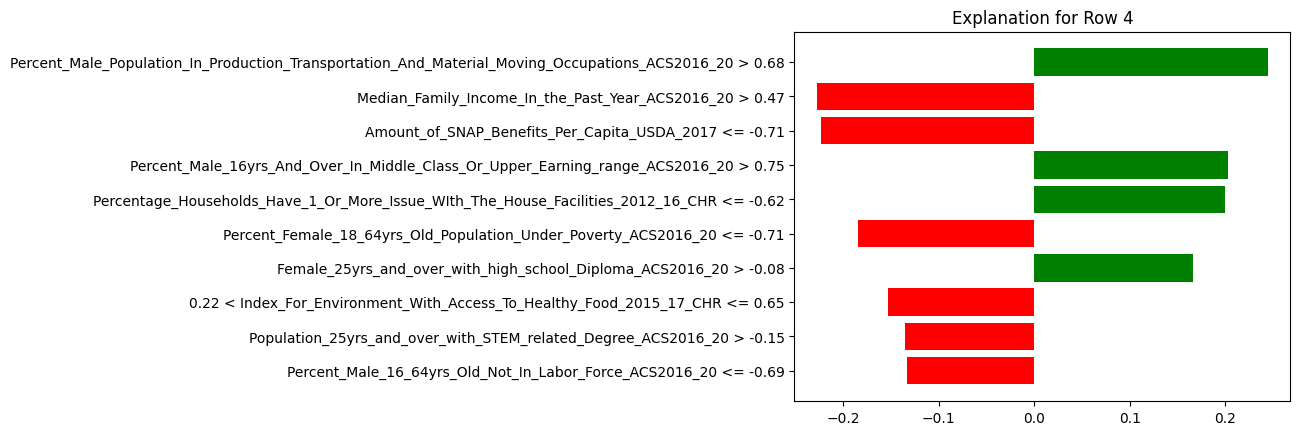

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


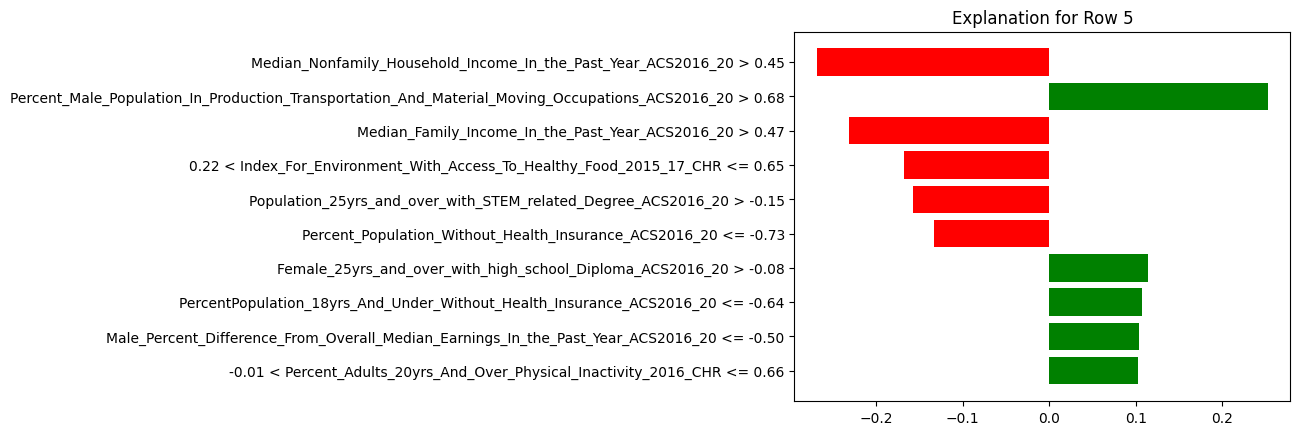

In [41]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()

# Initialize LIME explainer
explainer = LimeTabularExplainer(
    X_train_array,  # Training data
    feature_names=X_train.columns.tolist(),  # Feature names
    class_names=["Response"],  # Target variable name (optional for regression)
    mode='regression'  # Set mode to 'regression' for continuous targets
)

# Explain a prediction
row_to_explain = 0  # Choose a row from test set
explanation = explainer.explain_instance(
    X_test_array[row_to_explain],  # Instance to explain
    best_model.predict  # Prediction function
)

# Visualize explanation
explanation.show_in_notebook(show_table=True)
explanation.as_pyplot_figure()
plt.show()

# Repeat for multiple rows or save explanation for later
for i in range(5):  # First 5 rows as example
    explanation = explainer.explain_instance(X_test_array[i], best_model.predict)
    explanation.as_pyplot_figure()
    plt.title(f"Explanation for Row {i+1}")
    plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


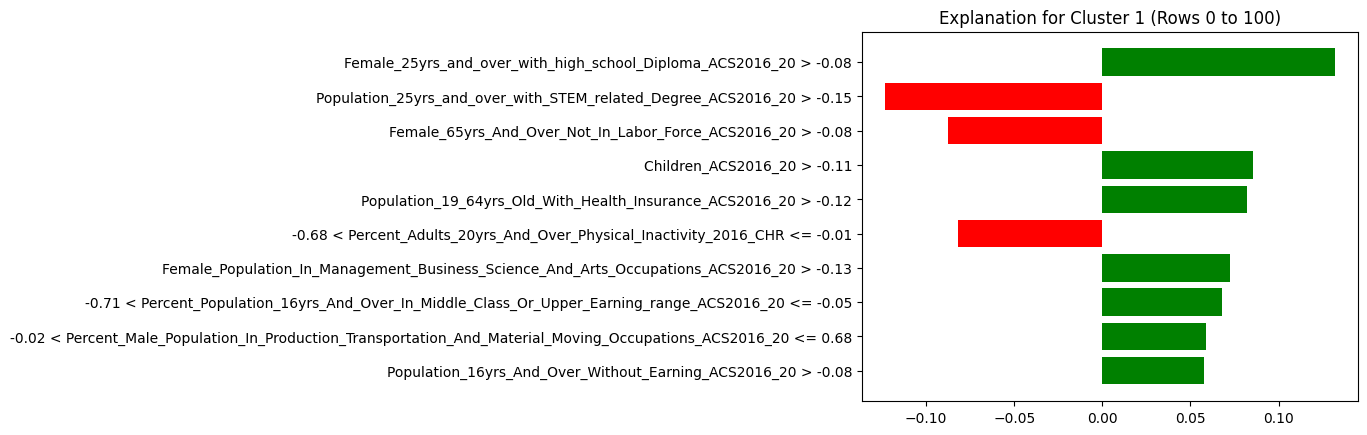

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


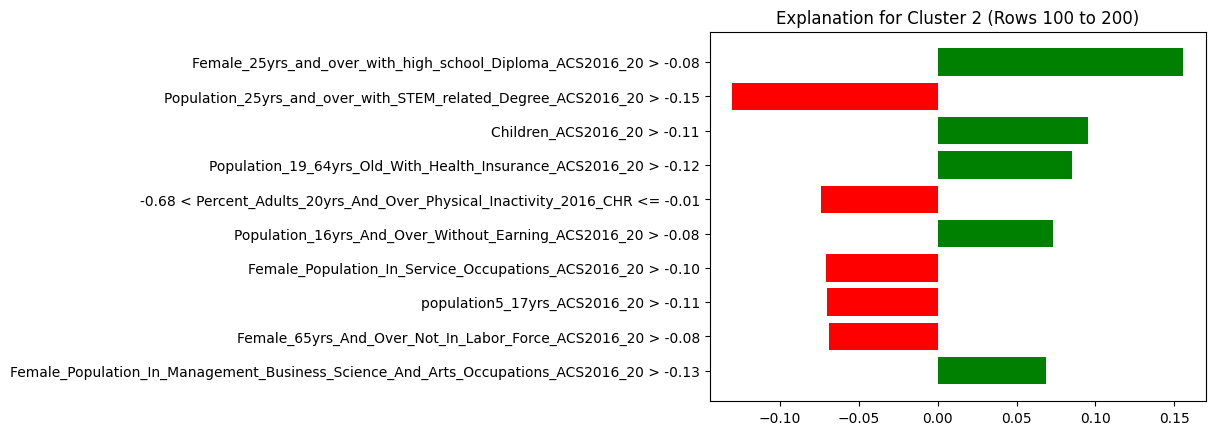

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


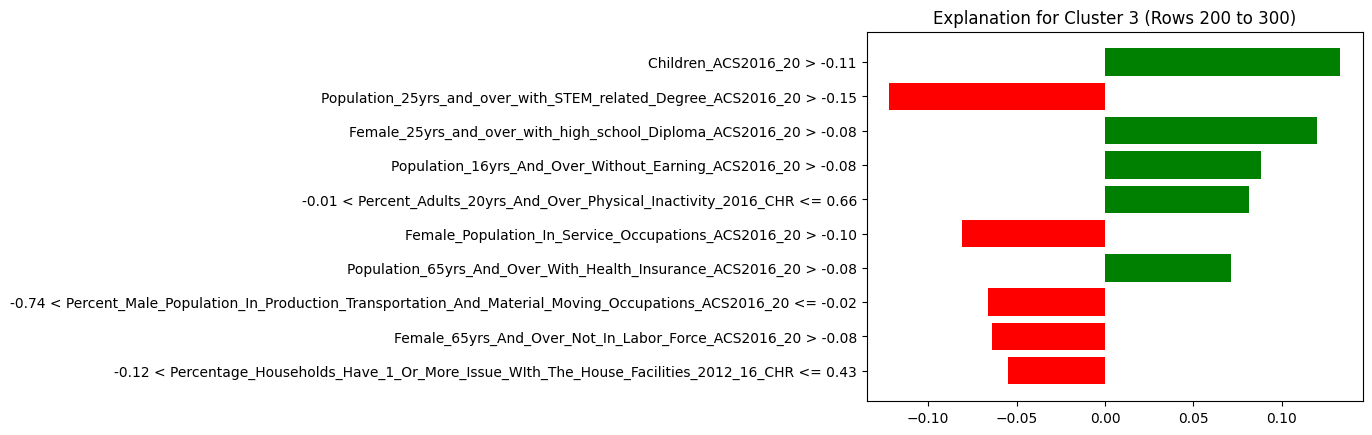

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


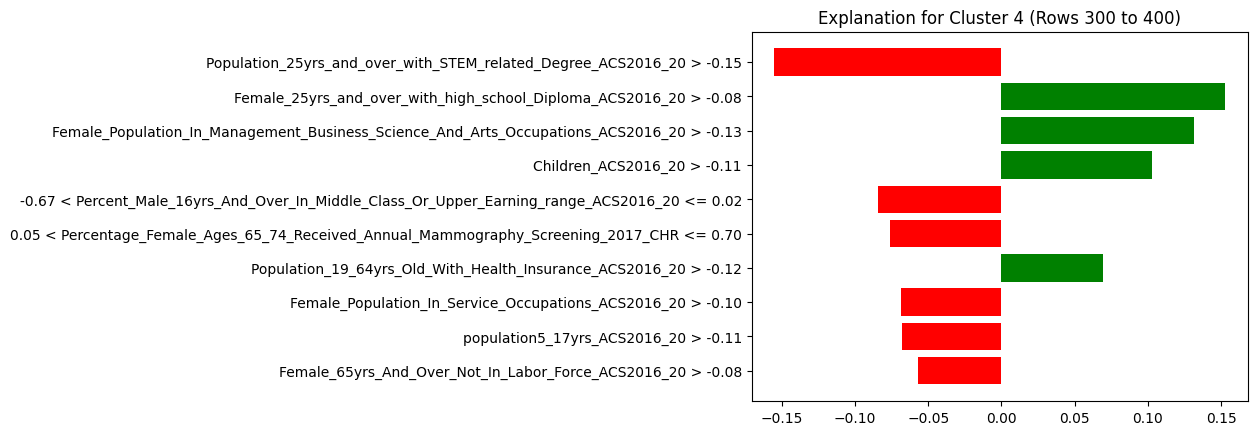

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step


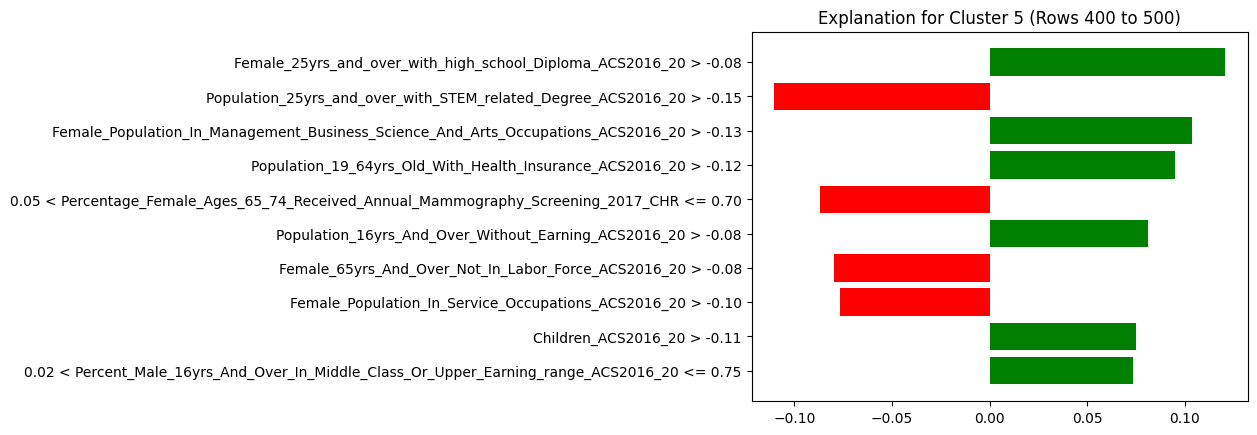

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step


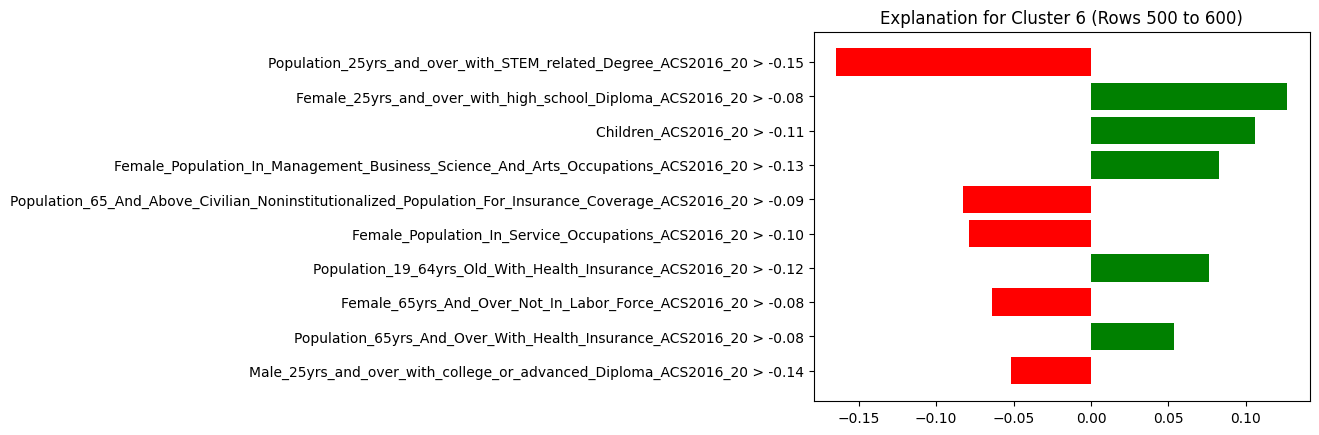

In [42]:
import numpy as np
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Convert data to numpy arrays
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()

# Initialize LIME explainer
explainer = LimeTabularExplainer(
    X_train_array,
    feature_names=X_train.columns.tolist(),
    class_names=["Response"],  # Optional for regression
    mode='regression'
)

# Define cluster size
cluster_size = 100

# Create clusters and explain each cluster
num_clusters = len(X_test) // cluster_size
for i in range(num_clusters):
    start_idx = i * cluster_size
    end_idx = start_idx + cluster_size
    
    # Compute the average feature values for the cluster
    cluster_representative = X_test_array[start_idx:end_idx].mean(axis=0)
    
    # Explain the representative row
    explanation = explainer.explain_instance(
        cluster_representative,
        best_model.predict
    )
    
    # Visualize the explanation
    explanation.as_pyplot_figure()
    plt.title(f"Explanation for Cluster {i+1} (Rows {start_idx} to {end_idx})")
    plt.show()


In [44]:
X_test

,Percent_Population_Without_Health_Insurance_ACS2016_20,PercentPopulation_18yrs_And_Under_Without_Health_Insurance_ACS2016_20,Population_19_64yrs_Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20,Population_19_64yrs_Old_With_Health_Insurance_ACS2016_20,Percent_Population_19_64yrs_Old_Without_Health_Insurance_ACS2016_20,Population_65_And_Above_Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20,Population_65yrs_And_Over_With_Health_Insurance_ACS2016_20,Population_16yrs_And_Over_Without_Earning_ACS2016_20,Percent_Population_16yrs_And_Over_Without_Earning_ACS2016_20,Percent_Population_16yrs_And_Over_In_Middle_Class_Or_Upper_Earning_range_ACS2016_20,...,Female_25yrs_and_over_with_high_school_Diploma_ACS2016_20,Population_25yrs_and_over_with_STEM_related_Degree_ACS2016_20,Index_For_Environment_With_Access_To_Healthy_Food_2015_17_CHR,Percent_Adults_20yrs_And_Over_Physical_Inactivity_2016_CHR,Percentage_Female_Ages_65_74_Received_Annual_Mammography_Screening_2017_CHR,Percentage_Households_Have_1_Or_More_Issue_WIth_The_House_Facilities_2012_16_CHR,Percent_Population_With_Low_Access_To_Store_USDA_2015,Percent_Household_With_Low_Income_And_Low_Access_to_Store_USDA_2015,Percent_Population_Under_18_With_Low_Access_To_Store_USDA_2015,Amount_of_SNAP_Benefits_Per_Capita_USDA_2017
2398,-0.841905,-0.846859,-0.296052,-0.299181,-0.519565,-0.336047,-0.337682,-0.315114,-0.653475,0.193085,...,-0.341491,-0.261194,-1.095177,-0.204843,0.829049,-1.649286,3.933137,2.695709,3.245485,-1.175220
2771,2.994707,4.139699,-0.280449,-0.287303,1.942728,-0.328823,-0.330364,-0.297433,-0.280589,0.467869,...,-0.324803,-0.261447,1.090624,-0.292617,-2.565464,-0.324918,-1.134930,-1.001972,-1.093685,0.139311
2671,1.884263,3.052811,-0.291948,-0.296230,1.218918,-0.337461,-0.339116,-0.312423,-0.880345,0.492266,...,-0.338623,-0.260662,-1.270041,0.128698,-1.520999,-1.349736,3.933114,2.340989,4.615737,-0.867076
2098,-0.861490,-0.476198,-0.006452,0.010639,-0.919001,0.066444,0.067117,-0.002301,-0.607619,0.741369,...,0.106859,-0.105182,0.653464,-0.239953,0.306816,-0.951949,-0.471223,-0.630023,-0.359880,-0.987862
1289,-1.088671,-0.827554,0.133299,0.166384,-1.087890,0.222857,0.227559,0.191341,-0.145433,0.602693,...,0.291798,-0.022768,0.653464,0.146253,-0.084859,-0.457416,-0.226114,-0.374780,-0.195648,-0.446715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929,1.660999,1.079809,-0.289514,-0.294351,1.508442,-0.337483,-0.339137,-0.310508,-0.801906,0.528219,...,-0.337584,-0.261650,-1.357473,0.269137,-2.696022,-0.391688,3.933137,3.471116,5.357915,-1.638788
60,-0.072233,-0.588168,-0.077324,-0.083403,0.032675,-0.051257,-0.049372,0.008836,0.758424,-0.800761,...,-0.005176,-0.204545,-0.395720,1.322426,-0.607091,-0.151259,-0.494162,-0.334287,-0.478630,0.359835
435,0.673938,0.367444,0.127049,0.102593,0.462939,0.009362,0.008395,0.089419,-0.718640,0.930123,...,0.169911,-0.033332,-0.658016,0.181363,-0.607091,0.532511,0.467230,0.626950,0.767712,0.253633
2951,0.100111,0.813396,-0.236846,-0.239876,-0.160341,-0.266896,-0.267624,-0.252508,-0.466429,0.548764,...,-0.262187,-0.211411,0.478600,1.041549,1.612398,0.291641,-0.555575,-0.608785,-0.486005,0.106601
